In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image using hough transform. 

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180


Which of the following pairs of (start, end) co-ordinates of detected lines are true:

1. line-1: (1,81), (27,9) ; line-2 : (92,0), (95,64)
2. line-1: (2,79), (26,11) ; line-2 : (92,1), (94,67)
3. line-1: (2,80), (26,10) ; line-2: (91,2), (96,65)
4.  None of the above

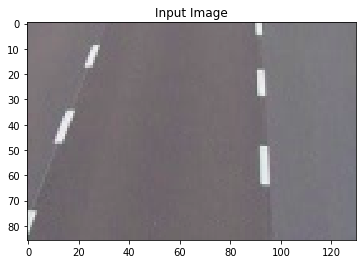

In [3]:
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

plt.imshow(img)
plt.title("Input Image")
plt.show()

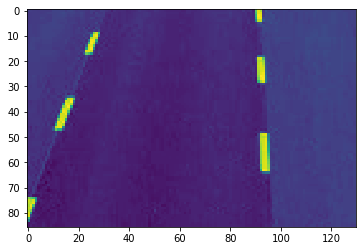

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

(Text(0.5, 1.0, 'Edge Image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

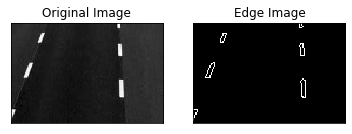

In [5]:
# Edges using Canny edge detector
edges = cv2.Canny(gray, 50, 200)
edges

plt.subplot(121),plt.imshow(gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

#### Hough Transform

In [6]:
# Paramters provided in the question
lines = cv2.HoughLinesP(edges,1, np.pi/180, 15,  minLineLength=60,maxLineGap=250 )

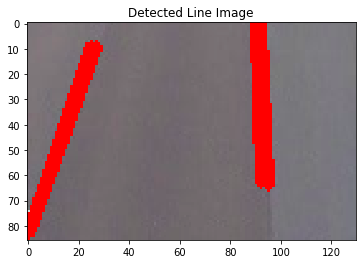

In [7]:
if lines is not None:
    for i in range(0, len(lines)):
        l = lines[i][0]
        cv2.line(img, (l[0],l[1]), (l[2],l[3]), (255,0,0), 3)
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()


# Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

Which of the following is the estimated number of inliers for an outlier rate of 0.9:

1. 89
2. 101
3. 117
4. 132

In [8]:
import numpy as np
np.random.seed(0)


In [9]:

# Affine Transform
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# pts_t =    A   * pts_s  + t

# -------------------------------------------------------------
# Test Class Affine

class AffineTransform():
    
    def create_test_case(self, outlier_rate=0):
        '''
        CREATE TEST CASE
        
        Randomly generate test case of affine trnasofrmation.
        
        Input argements:
        - outlier rate : percetnage of outliers in test case.
        
        Outputs:
        - pts_s - Source poinst that will be trandformed.
        - pts_t : warped poinns, 
        -A, t paramters of Affine transformation
            - A is 2*2 matrix, 
            - t is 2*1 matrix
        '''
        
        # Randomly generate affine transforamtion
        A = 4* np.random.rand(2,2) - 2
        
        t = 20* np.random.rand(2, 1) - 10
        
        #no pof points in test case
        num = 1000
        
        # No of outleirs
        outliers = int(np.round(num* outlier_rate))
        inliers = int(num - outliers)
        
        # Gernerate source points whose scope from (0,0) to (100, 100)
        pts_s = 100 * np.random.rand(2, num)
        # Initialize warped points matrix
        pts_t = np.zeros((2, num))
        
        # Compute inliers in warped points matrix by applying A and t 
        pts_t[:,:inliers] = np.dot(A, pts_s[:, :inliers]) + t
        
        # Generate outlers in warped oonts matrix 
        pts_t[:, inliers:] = 100* np.random.rand(2, outliers)
        
        # reset order of warped oiunts matrix
        # inlies and outliers will scaller andom;
        rnd_idx = np.random.permutation(num)
        pts_s= pts_s[:, rnd_idx]
        pts_t= pts_t[:, rnd_idx]
        
        return A, t, pts_s, pts_t
    
    
    def estimate_affine(self, pts_s, pts_t):
        """
        ESTIMATE AFFINE
        
        estimate affine transformation by given points correspondence.
        
        Input arguements:
        pts_t : points in target image,
        pts_s: points in source image.
        
        outputs:
        A: affine transformation that is 2*2 matrix
        t: scaling transformation that is 2*1 matrix.
        
        
        Merhod:
        To estimate affine transformation between two images atleast 3 corresponding points are neede.
        In this case 6 paramtera ffine transforation is taken
        
        | x' | = | a b | * | x | + | tx |
        | y' |   | c d |   | y |   | ty |
        
          For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |
            
            
         Solve the equation to compute theta by:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |
                
        """
        
        # get the number of corresponding points
        pts_num = pts_s.shape[1]
        
        # Initialize M, M has 6 columsn, since affine trnasformation has 6 paramters in this case.
        M = np.zeros((2 * pts_num, 6))
        
        # Now, form the matrix. 
        
        for i in range(pts_num):
            temp =[[pts_s[0, i], pts_s[1, i], 0, 0, 1, 0],
                  [0, 0, pts_s[0, i], pts_s[1, i], 0, 1]]
            M[2*i:2*i+2,:]= np.array(temp)
        
        # form the matrix b
        b =pts_s.T.reshape((2* pts_num, 1))
        
        # Now solve Linear system of equation
        try:
            theta = np.linalg.lstsq(M, b)[0]
            
            # form the affine trnasformation
            A= theta[:4].reshape((2,2))
            t= theta[4:]
        except np.linalg.linalg.LinAlgError:
                A=None
                b =None
            
        return A, t
            

In [10]:
af = AffineTransform()
outlier_rate = 0.9
A_true, t_true, pts_s, pts_t =af.create_test_case(outlier_rate)
print(A_true)
print(t_true)
print(pts_s)
print(pts_t)

[[0.19525402 0.86075747]
 [0.4110535  0.17953273]]
[[-1.52690401]
 [ 2.91788226]]
[[96.61474456 79.55903685 52.8939929  ... 26.33223767 78.32344383
  52.49704423]
 [56.66693394 93.71230205 19.68520547 ...  5.10073088 53.39779236
  22.18240305]]
[[78.50663791 63.25089743 37.74301852 ... 18.35044671 87.9417462
   3.16054428]
 [25.01011098  8.7887882  62.66134356 ... 42.94665852 72.90155103
  50.12363118]]


In [11]:
K = 3
idx = np.random.randint(0, pts_s.shape[1], (K, 1))

A_test, t_test = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])


<ipython-input-9-141726b032e1>:118: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(M, b)[0]


In [12]:
# Display known parameters with estimations
# They should be same when outlier_rate equals to 0,
# otherwise, they are totally different in some cases

print(A_true, '\n', t_true)
print(A_test, '\n', t_test)

[[0.19525402 0.86075747]
 [0.4110535  0.17953273]] 
 [[-1.52690401]
 [ 2.91788226]]
[[ 1.00000000e+00 -2.01264534e-15]
 [-1.33226763e-15  1.00000000e+00]] 
 [[ 1.38154545e-13]
 [-6.88425011e-14]]


# RANSAC

In [25]:
import numpy as np
np.random.seed(0)


# Affine Transform
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# pts_t =    A   * pts_s  + t

# -------------------------------------------------------------
# Test Class Affine

class Affine_Transform():

    def create_test_case(self, outlier_rate=0):
        ''' CREATE_TEST_CASE

            Randomly generate a test case of affine transformation.

            Input arguments:

            - outlier_rate : the percentage of outliers in test case,
            default is 0

            Outputs:

            - pts_s : Source points that will be transformed
            - pts_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''

        # Randomly generate affine transformation
        # A is a 2x2 matrix, the range of each value is from -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # % t is a 2x1 VECTOR, the range of each value is from -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the number of points in test case
        num = 1000

        # Compute the number of outliers and inliers respectively
        outliers = int(np.round(num * outlier_rate))
        inliers = int(num - outliers)

        # Gernerate source points whose scope from (0,0) to (100, 100)
        pts_s = 100 * np.random.rand(2, num)
        # Initialize warped points matrix
        pts_t = np.zeros((2, num))

        # Compute inliers in warped points matrix by applying A and t
        pts_t[:, :inliers] = np.dot(A, pts_s[:, :inliers]) + t

        # Generate outliers in warped points matrix
        pts_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix,
        # outliers and inliers will scatter randomly in test case
        rnd_idx = np.random.permutation(num)
        pts_s = pts_s[:, rnd_idx]
        pts_t = pts_t[:, rnd_idx]

        return A, t, pts_s, pts_t

    def estimate_affine(self, pts_s, pts_t):
        ''' ESTIMATE_AFFINE

            Estimate affine transformation by the given points
            correspondences.

            Input arguments:
            - pts_t : points in target image
            - pts_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation to compute theta by:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        # Get the number of corresponding points
        pts_num = pts_s.shape[1]

        # Initialize the matrix M,
        # M has 6 columns, since the affine transformation
        # has 6 parameters in this case
        M = np.zeros((2 * pts_num, 6))

        for i in range(pts_num):
            # Form the matrix m
            temp = [[pts_s[0, i], pts_s[1, i], 0, 0, 1, 0],
                    [0, 0, pts_s[0, i], pts_s[1, i], 0, 1]]
            M[2 * i: 2 * i + 2, :] = np.array(temp)

        # Form the matrix b,
        # b contains all known target points
        b = pts_t.T.reshape((2 * pts_num, 1))

        try:
            # Solve the linear equation
            theta = np.linalg.lstsq(M, b)[0]

            # Form the affine transformation
            A = theta[:4].reshape((2, 2))
            t = theta[4:]
        except np.linalg.linalg.LinAlgError:
            # If M is singular matrix, return None
            # print("Singular matrix.")
            A = None
            t = None

        return A, t
# -------------------------------------------------------------

# Create instance
af = Affine_Transform()

# Generate a test case as validation with
# a rate of outliers
outlier_rate = 0.90
A_true, t_true, pts_s, pts_t = af.create_test_case(outlier_rate)

# At least 3 corresponding points to
# estimate affine transformation
K = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, pts_s.shape[1], (K, 1))

A_test, t_test = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])

# Display known parameters with estimations
# They should be same when outlier_rate equals to 0,
# otherwise, they are totally different in some cases
#print(A_true, '\n', t_true)
#print(A_test, '\n', t_test)

# -------------------------------------------------------------
# Test Class Ransac
# The number of iterations in RANSAC
ITER_NUM = 2000


class Ransac():

    def __init__(self, K=3, threshold=1):
        ''' __INIT__

            Initialize the instance.

            Input argements:

            - K : the number of corresponding points,
            default is 3
            - threshold : determing which points are inliers
            by comparing residual with it

        '''

        self.K = K
        self.threshold = threshold

    def residual_lengths(self, A, t, pts_s, pts_t):
        ''' RESIDUAL_LENGTHS

            Compute residual length (Euclidean distance) between
            estimation and real target points. Estimation are
            calculated by the given source point and affine
            transformation (A & t).

            Input arguments:

            - A, t : the estimated affine transformation calculated
            by least squares method
            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - residual : Euclidean distance between estimated points
            and real target points

        '''

        if not(A is None) and not(t is None):
            # Calculate estimated points:
            # pts_e = A * pts_s + t
            pts_e = np.dot(A, pts_s) + t

            # Calculate the residual length between estimated points
            # and target points
            diff_square = np.power(pts_e - pts_t, 2)
            residual = np.sqrt(np.sum(diff_square, axis=0))
        else:
            residual = None

        return residual

    def ransac_fit(self, pts_s, pts_t):
        ''' RANSAC_FIT

            Apply the method of RANSAC to obtain the estimation of
            affine transformation and inliers as well.

            Input arguments:

            - pts_s : key points from source image
            - pts_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers that will be applied to refine the
            affine transformation

        '''
        #### YOUR CODE START HERE
        # Create a Affine instance to do estimation
        af = Affine_Transform()

        # Initialize the number of inliers
        inliers_num = 0

        # Initialize the affine transformation A and t,
        # and a vector that stores indices of inliers
        A = None
        t = None
        inliers = None

        for i in range(ITER_NUM):
            # Randomly generate indices of points correspondences
            idx = np.random.randint(0, pts_s.shape[1], (self.K, 1))
            # Estimate affine transformation by these points
            A_tmp, t_tmp = af.estimate_affine(pts_s[:, idx], pts_t[:, idx])

            # Calculate the residual by applying estimated transformation
            residual = self.residual_lengths(A_tmp, t_tmp, pts_s, pts_t)

            if not(residual is None):
                # Obtain the indices of inliers
                inliers_tmp = np.where(residual < self.threshold)
                # Obtain the number of inliers
                inliers_num_tmp = len(inliers_tmp[0])

                # Set affine transformation and indices of inliers
                # in one iteration which has the most of inliers
                if inliers_num_tmp > inliers_num:
                    # Update the number of inliers
                    inliers_num = inliers_num_tmp
                    # Set returned value
                    inliers = inliers_tmp
                    A = A_tmp
                    t = t_tmp
            else:
                pass
        ### YOUR CODE ENDS HERE
        return A, t, inliers


<ipython-input-25-3047565c53c6>:132: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(M, b)[0]


(101,)


In [26]:

# Create instance
rs = Ransac(K=3, threshold=1)

residual = rs.residual_lengths(A_test, t_test, pts_s, pts_t)

# Run RANSAC to estimate affine transformation when
# too many outliers in points set
A_rsc, t_rsc, inliers = rs.ransac_fit(pts_s, pts_t)
#print(A_rsc, '\n', t_rsc)
# print the number of inliners or point matches
print (inliers[0].shape)


<ipython-input-25-3047565c53c6>:132: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(M, b)[0]


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

which of the following are true?

1.   169
2.   222
3.   264
4.   309


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

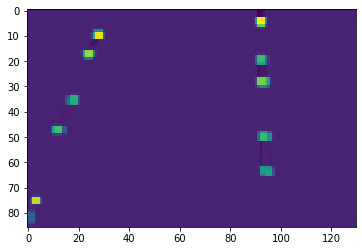

In [29]:
image = cv2.imread('line.png')
image_copy = np.copy(image)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
gray_img = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
gray_img = np.float32(gray_img)

# detect corvers.
dilst = cv2.cornerHarris(gray_img, 2,3, 0.04)
# dilation
dilst = cv2.dilate(dilst, None)
plt.imshow(dilst)



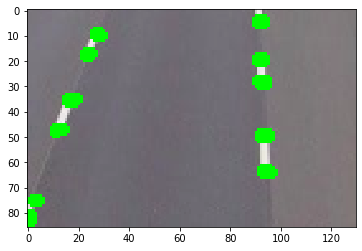

In [31]:
thresh = 0.1 * dilst.max()
# no of detected norner.
corner_image = np.copy(image_copy)

count =0 
for j in range(0, dilst.shape[0]):
    for i in range(0, dilst.shape[1]):
        if(dilst[j, i] > thresh):
            count += 1
            cv2.circle(corner_image, (i, j), 1, (0,255,0), 1)
plt.imshow(corner_image)        

# Pytorch

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

In [47]:
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [49]:
# check availability of GPU and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a set of transforms for preparing the dataset
transform = transforms.Compose([
        transforms.ToTensor(), # convert the image to a pytorch tensor
        transforms.Normalize((0.1307,), (0.3081,)) # normalise the images with mean and std of the dataset
        ])

In [50]:
# load mnist dataset
train_dataset = datasets.MNIST('./data', train=True, download = True, transform = transform)

test_dataset = datasets.MNIST('../data', train=False, download = True, transform= transform)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...


/home/prajin/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


In [53]:
# create data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=32)


In [69]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(7744, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output
        

In [70]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.016s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [71]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss =F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 ==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [72]:
def test(model, device, test_loader):
    model.eval()
    test_loss=0
    correct =0 
    with torch.no_grad():
        for data,target in test_loader:
            data, target= data.to(device), target.to(device)
            output = model(data)
            test_loss= F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [73]:
model = Net().to(device)

# ADAM
optimizer = optim.Adam(model.parameters(), lr =0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306224
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.088397
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.091689
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.289884
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.409403
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.346790
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.366338
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.641968
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.314556
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.581146
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.296925
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.393451
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.594117
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.578306
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.398371
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.208833
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.429052
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.366508
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.506299
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.313874
Train Epoch: 1 [12800/60000 (

KeyboardInterrupt: 

In [74]:
# Using activation as Sigmoid
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.conv3(x)
        x = torch.sigmoid(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [75]:
model = NetSigmoid().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325490
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.342017
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.255521
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.445716
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.474895
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.435985


KeyboardInterrupt: 

# Initialization with ones

In [77]:
model = Net().to(device)
def init_weiights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.ones_(m.weight.data)
        torch.nn.init.ones_(m.bias.data)
model.apply(init_weiights)  


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=7744, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [79]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 5):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start))) 

Train Epoch: 1 [0/60000 (0%)]	Loss: 153080.562500
Train Epoch: 1 [640/60000 (1%)]	Loss: 4725.473145
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305116
Train Epoch: 1 [1920/60000 (3%)]	Loss: 6774.048340
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.299091
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.300047
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.290866


KeyboardInterrupt: 

# Xvier Initialization

In [80]:
model = Net().to(device)
def init_wights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
model.apply(init_wights)


Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=7744, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [81]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()

for epoch in range(1, 5):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)

stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314250
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.221250
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.350546
Train Epoch: 1 [1920/60000 (3%)]	Loss: 1.189011
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.466287
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.432858
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.434421
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.433257
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.379105
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.251577


KeyboardInterrupt: 

# Adding batchNorm Layers

In [82]:
class NetBatchNorm(nn.Module):
    def __init__(self):
        super(NetBatchNorm, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        # define a batchnorm layer (2d) with 16 features
        self.bn1 = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        # define a batchnorm layer (2d) with 32 features
        self.bn2 = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, 3, 1)
        # define a batchnorm layer (2d) with 64 features
        self.bn3 = nn.BatchNorm2d(64)
        # define dropout layer with a probability of 0.25
        self.dropout1 = nn.Dropout2d(0.25)
        # define dropout layer with a probability of 0.5
        self.dropout2 = nn.Dropout2d(0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(7744, 128)
        # self.bn1 = nn.BatchNorm2d(128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, 10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [83]:
model = NetBatchNorm().to(device)

## Define Adam Optimiser with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.01)

start = timeit.default_timer()
for epoch in range(1, 11):
    train(model, device, train_dataloader, optimizer, epoch)
    test(model, device, test_dataloader)
stop = timeit.default_timer()
print('Total time taken: {} seconds'.format(int(stop - start)) )

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.383615
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.054671
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.637492


KeyboardInterrupt: 